In [10]:
import os.path as osp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from fontTools.misc.psOperators import ps_dict

from sklearn.model_selection import train_test_split


In [11]:
DATA_ROOT_PATH = "../metadata"
SEED = 777
np.random.seed(SEED)
SPLIT_RATIO = 0.9


train_data_2023 = pd.read_csv(osp.join(DATA_ROOT_PATH, "FungiCLEF2023_train_metadata_PRODUCTION.csv"))
# val_data = pd.read_csv(osp.join(DATA_ROOT_PATH, "FungiCLEF2023_val_metadata_PRODUCTION.csv"))
# data_df = pd.concat([train_data, val_data])
data_df = train_data_2023
len(data_df)


295938

In [12]:
def make_df() -> pd.DataFrame:
    train_df20 = pd.read_csv(osp.join(DATA_ROOT_PATH, "DF20-train_metadata_PROD-2.csv"))
    test_df20  = pd.read_csv(osp.join(DATA_ROOT_PATH, "DF20-public_test_metadata_PROD-2.csv"))
    df20 = pd.concat([train_df20, test_df20]).reset_index(drop=True)
    return df20
    

In [13]:
def make_mini() -> pd.DataFrame:
    train_mini = pd.read_csv("../metadata/DF20M-train_metadata_PROD.csv")
    test_mini = pd.read_csv("../metadata/DF20M-public_test_metadata_PROD.csv")

    df20m = pd.concat([train_mini, test_mini]).reset_index(drop=True)

    df20m = df20m.reset_index(drop=True)
    return df20m
    

In [14]:
MAKE_MINI = False
if MAKE_MINI:
    df20m = make_mini()
    unique_genus = df20m["genus"].unique()
    data_df = data_df[data_df["genus"].isin(unique_genus)].reset_index(drop=True)
    assert len(df20m) == len(data_df), "Not same length!"
else:
    df20 = make_df()
    unique_genus = df20["genus"].unique()
    data_df = data_df[data_df["genus"].isin(unique_genus)].reset_index(drop=True)
    assert len(df20) == len(data_df), "Not same length!"
    
len(data_df)


295938

In [18]:
data_df.head()

,observationID,year,month,day,countryCode,locality,taxonID,scientificName,kingdom,phylum,...,Substrate,rightsHolder,Latitude,Longitude,CoorUncert,Habitat,image_path,class_id,MetaSubstrate,poisonous
0,2238546328,2018.0,4.0,16.0,DK,Ulvedal Plantage,30872.0,Ramalina farinacea (L.) Ach.,Fungi,Ascomycota,...,bark of living trees,Ulfva Melchior Hvidegaard,56.299706,9.258110,50.0,Mixed woodland (with coniferous and deciduous ...,2238546328-30620.JPG,1273,wood,0
1,2558871973,2020.0,1.0,3.0,DK,Slotshegn,15256.0,Hysterium acuminatum Fr.,Fungi,Ascomycota,...,dead wood (including bark),Ole Martin,55.861899,11.975973,50.0,Deciduous woodland,2558871973-53941.JPG,708,wood,0
2,2238503501,2017.0,8.0,22.0,DK,Petersborg Strandenge,61200.0,Gliophorus perplexus (A.H.Sm. & Hesler) Kovalenko,Fungi,Basidiomycota,...,soil,Per Taudal Poulsen,56.975158,9.285525,75.0,natural grassland,2238503501-245559.JPG,535,jord,0
3,2446759075,2019.0,10.0,26.0,DK,Klintebjerg,30530.0,Lecidella scabra (Taylor) Hertel & Leuckert,Fungi,Ascomycota,...,stone,Susanne Rabenborg,55.960242,11.583103,15.0,gravel or clay pit,2446759075-197643.JPG,832,stone,0
4,2238472345,2016.0,8.0,21.0,DK,Blåbjerg,63728.0,"Russula fragilis Fr., 1838",Fungi,Basidiomycota,...,soil,Tom Smidth,55.742985,8.250188,50.0,Mixed woodland (with coniferous and deciduous ...,2238472345-167057.JPG,1338,jord,0


In [19]:
if not "class_id" in data_df.columns.values:
    from sklearn import preprocessing
    
    le = preprocessing.LabelEncoder()
    
    data_df = data_df.sort_values("scientificName")
    data_df['class_id'] = le.fit_transform(data_df['scientificName']).astype(np.int64)
    data_df = data_df.sort_index()
    data_df.head()

1604


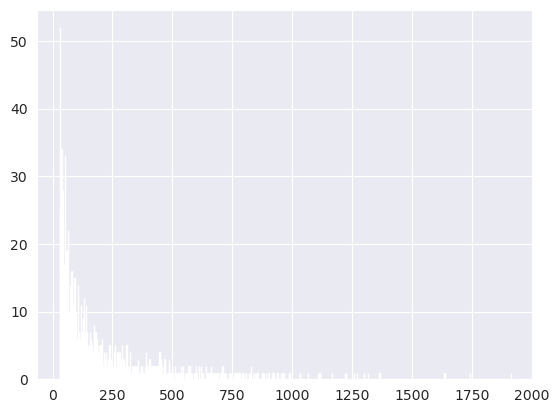

In [25]:
print(len(data_df["class_id"].unique()))
class_counts = data_df.groupby(by="class_id").count()["observationID"].sort_values()
class_counts.hist(bins=len(data_df["class_id"].unique()))
plt.show()

In [23]:

data_df.groupby(by="class_id")["observationID"].unique()

class_id
0       [2238476564, 2984618340, 2238424107, 242182127...
1       [2864904317, 2239703851, 2238544564, 259238001...
2       [2549106880, 2238208159, 2238409127, 257511852...
3       [2238144111, 2238141004, 2237858884, 223786186...
4       [2238380265, 2238411888, 2452381242, 287430030...
                              ...                        
1599    [2238151256, 2851421319, 2238205122, 223844667...
1600    [2238537798, 2238578047, 2238150963, 223814020...
1601    [2238488781, 2238408125, 2237952657, 223802997...
1602    [2238486196, 2238483519, 2238537922, 255615059...
1603    [2981231346, 2984621301, 2984616407, 223814246...
Name: observationID, Length: 1604, dtype: object

In [26]:
def initial_train_val_split(data_df):
    in_class_unique_observation_ids = data_df.groupby(by="class_id")["observationID"].unique()

    train_indexes, val_indexes = [], []
    for single_class_obs_ids in in_class_unique_observation_ids:  # Observation IDs in one class
        # Split the observations in the ratio
        train_ids, val_ids = train_test_split(single_class_obs_ids, train_size=SPLIT_RATIO, random_state=SEED)
        # Get indexes
        train_indexes += list(data_df[data_df["observationID"].isin(train_ids)].index)
        val_indexes += list(data_df[data_df["observationID"].isin(val_ids)].index)

    train_df = data_df.iloc[train_indexes]
    val_df = data_df.iloc[val_indexes]
    return train_df, val_df


In [27]:
def initial_train_val_split_class_only(data_df):
    num_classes = len(data_df["class_id"].unique())
    train_indexes, val_indexes = [], []
    for class_id in range(num_classes):
        single_class_data = data_df[data_df["class_id"] == class_id]
        train_single_class, val_single_class = train_test_split(single_class_data, train_size=SPLIT_RATIO, random_state=SEED)
        # Get indexes
        train_indexes += list(train_single_class.index)
        val_indexes += list(val_single_class.index)

    train_df = data_df.iloc[train_indexes]
    val_df = data_df.iloc[val_indexes]
    return train_df, val_df
    

In [29]:
USE_OBS_SPLIT = True
if USE_OBS_SPLIT:
    train_df, val_df = initial_train_val_split(data_df)
else:
    train_df, val_df = initial_train_val_split_class_only(data_df)

train_df.head()

,observationID,year,month,day,countryCode,locality,taxonID,scientificName,kingdom,phylum,...,Substrate,rightsHolder,Latitude,Longitude,CoorUncert,Habitat,image_path,class_id,MetaSubstrate,poisonous
1718,2238476564,2016.0,9.0,30.0,DK,Kalvebod Fælled,10000.0,Abortiporus biennis (Bull.) Singer,Fungi,Basidiomycota,...,NaN,Martin Schier Christiansen,55.598923,12.549613,25.0,meadow,2238476564-93258.JPG,0,wood,0
2033,2238424107,2015.0,9.0,12.0,DK,Lekkende Hovskov,10000.0,Abortiporus biennis (Bull.) Singer,Fungi,Basidiomycota,...,soil,Leo de Jong,55.069340,11.995640,50.0,Deciduous woodland,2238424107-313477.JPG,0,jord,0
2946,2421821274,2019.0,9.0,23.0,DK,Øksenrade Skov,10000.0,Abortiporus biennis (Bull.) Singer,Fungi,Basidiomycota,...,dead wood (including bark),Jette Anitha Hansen,55.494999,9.713562,75.0,Unmanaged deciduous woodland,2421821274-119046.JPG,0,wood,0
3150,2238479506,2016.0,10.0,11.0,DK,"Vestre Kirkegård, København",10000.0,Abortiporus biennis (Bull.) Singer,Fungi,Basidiomycota,...,soil,Ane Brødsgaard,55.658221,12.528616,75.0,park/churchyard,2238479506-241917.JPG,0,jord,0
3870,2864905404,2020.0,9.0,24.0,DK,Povlinelund,10000.0,Abortiporus biennis (Bull.) Singer,Fungi,Basidiomycota,...,dead wood (including bark),Dan Schou,55.042809,10.551658,10.0,Mixed woodland (with coniferous and deciduous ...,2864905404-138020.JPG,0,wood,0


/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


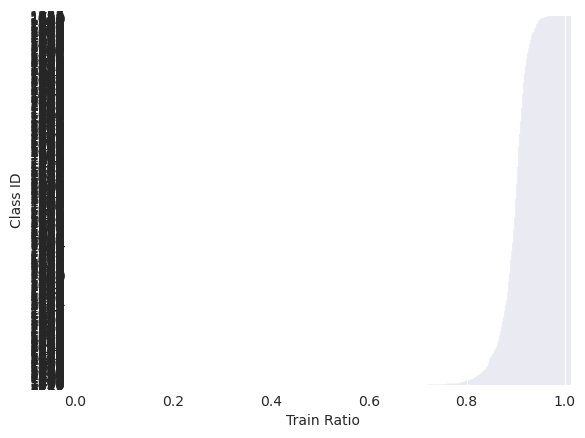

/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


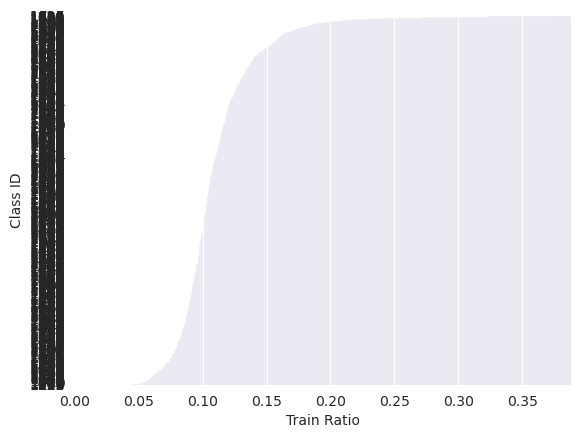

In [30]:
def plot_ratio_barplot(original_df, target_df, iteration=None, save=False):
    in_class_ratios = target_df.groupby(by="class_id").count()["observationID"] / original_df.groupby(by="class_id").count()["observationID"]
    in_class_ratios = in_class_ratios.sort_values()
    ax = sns.barplot(
        x=in_class_ratios.values,
        y=in_class_ratios.index,
        orient="h",
        order=in_class_ratios.index[::-1]
    )
    ax.set(xlabel='Train Ratio', ylabel='Class ID', title=f"Iteration: {iteration}" if iteration else "")
    if save:
        plt.savefig(f"../metadata/final_distribution{'_mini' if MAKE_MINI else ''}.png")
    plt.show()
    # print(original_df["observationID"].isin(target_df["observationID"]).sum())

plot_ratio_barplot(data_df, train_df)
plot_ratio_barplot(data_df, val_df)
    

In [31]:
def move_data_by_threshold(
        source_df: pd.DataFrame,
        target_df: pd.DataFrame,
        cls_threshold_sequence: pd.Series,
) -> (pd.DataFrame, pd.DataFrame):

    data_to_be_moved = []
    try_to_move_from_target = []
    for cls_ids_to_move in cls_threshold_sequence.index:
        cls_data = source_df[source_df["class_id"] == cls_ids_to_move]
        if len(cls_data["observationID"].unique()) > 1:
            chosen_observation = np.random.choice(cls_data["observationID"].unique())
            data_to_be_moved.append(source_df[source_df["observationID"] == chosen_observation])
        else:  # Only single observation in source -> try to move a random observation from target
            cls_data = target_df[target_df["class_id"] == cls_ids_to_move]
            if len(cls_data["observationID"].unique()) > 1:
                chosen_observation = np.random.choice(cls_data["observationID"].unique())
                try_to_move_from_target.append(target_df[target_df["observationID"] == chosen_observation])

    if data_to_be_moved:
        data_to_be_moved = pd.concat(data_to_be_moved)
        target_df = pd.concat([target_df, data_to_be_moved])
        source_df = source_df.drop(data_to_be_moved.index)
    if try_to_move_from_target:
        try_to_move_from_target = pd.concat(try_to_move_from_target)
        source_df = pd.concat([source_df, try_to_move_from_target])
        target_df = target_df.drop(try_to_move_from_target.index)

    return source_df, target_df
    

/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


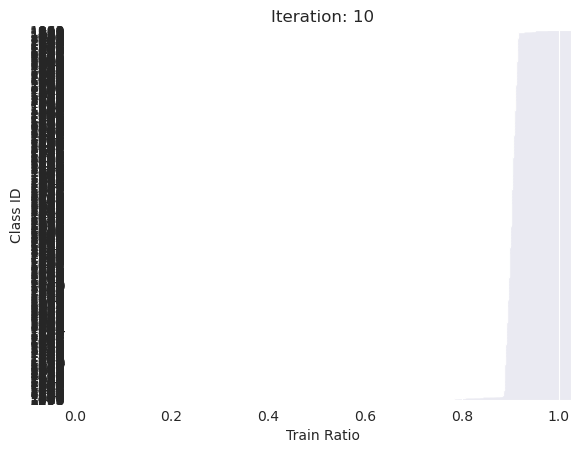

/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


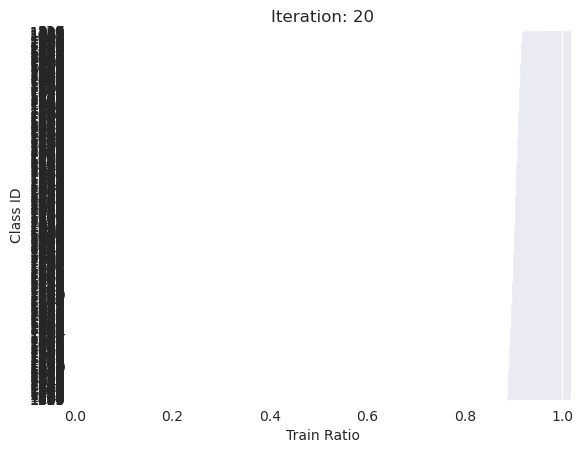

/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


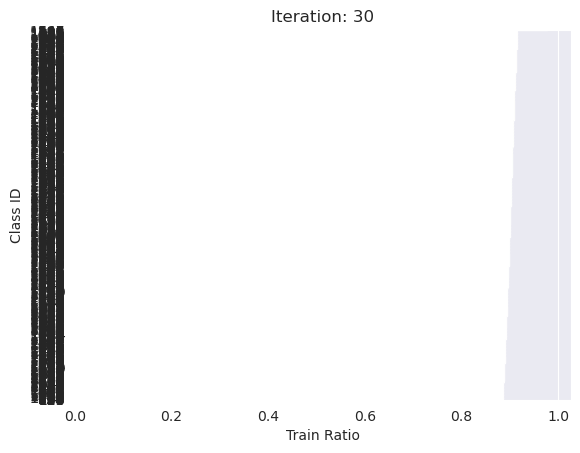

/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


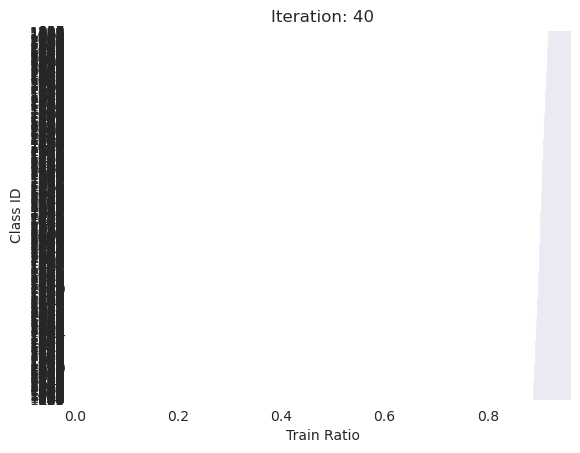

/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


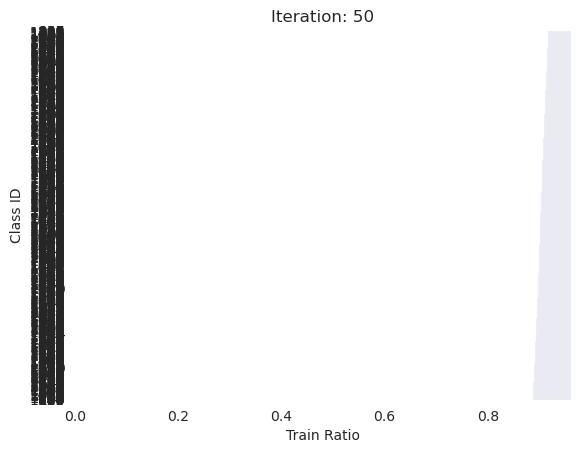

/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


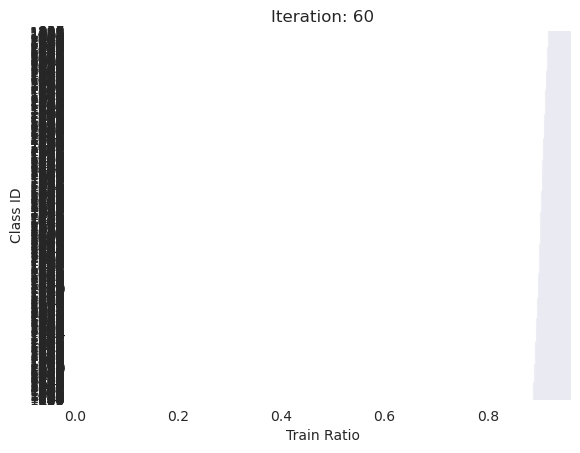

/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


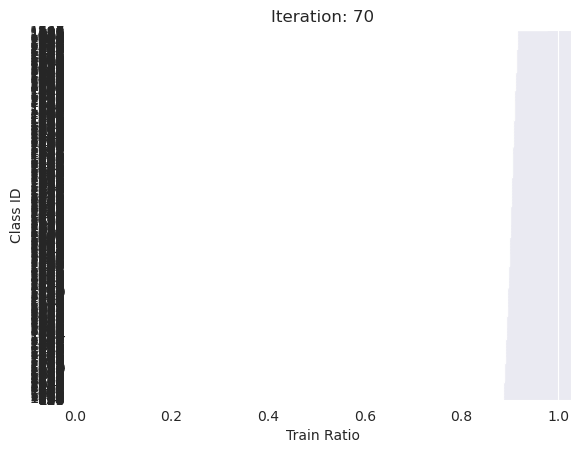

/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


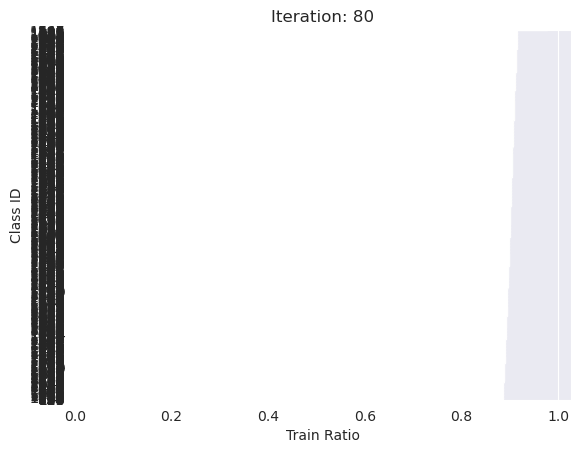

/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


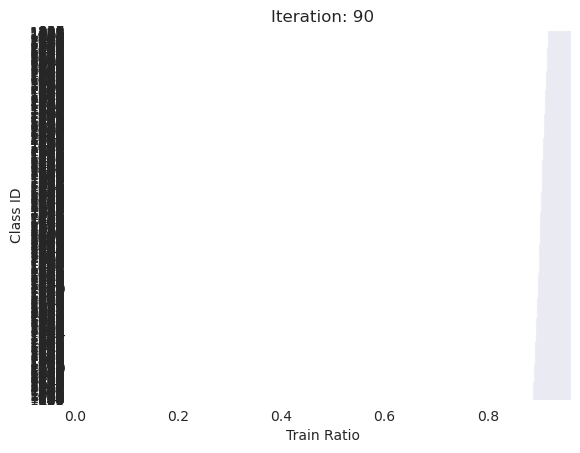

/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


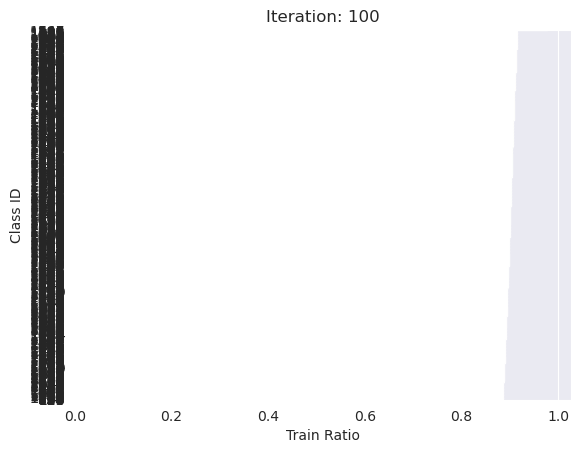

In [32]:
TARGET_INTERVAL_SIZE = 0.015  #2
NUM_ITERATIONS = 100

for i in range(1, NUM_ITERATIONS+1):
    in_class_ratios = train_df.groupby(by="class_id").count()["observationID"] / data_df.groupby(by="class_id").count()["observationID"]
    down_threshold = in_class_ratios[in_class_ratios < SPLIT_RATIO - TARGET_INTERVAL_SIZE]
    upper_threshold = in_class_ratios[in_class_ratios > SPLIT_RATIO + TARGET_INTERVAL_SIZE]
    if len(upper_threshold) == 0 and len(down_threshold) == 0:
        break

    train_df, val_df = move_data_by_threshold(train_df, val_df, upper_threshold)
    val_df, train_df = move_data_by_threshold(val_df, train_df, down_threshold)

    if i % 10 == 0:
        plot_ratio_barplot(data_df, train_df, iteration=i)
        

/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/marek/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


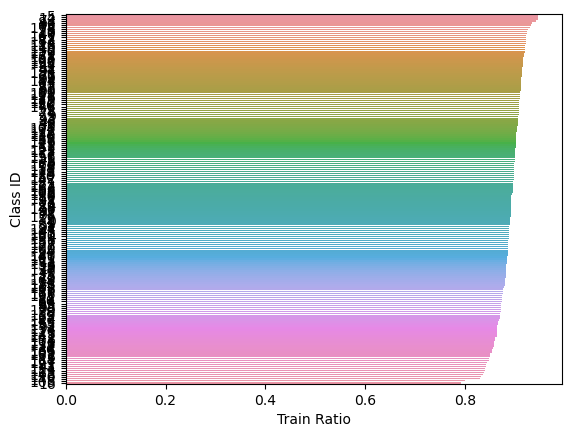

32524


0.893688346660072

In [29]:
assert train_df["observationID"].isin(val_df["observationID"]).sum() == 0, "Mixed observations!"
assert len(data_df) == (len(train_df) + len(val_df)), "Start and end amount of data does not correspond!"

plot_ratio_barplot(data_df, train_df, save=False)

original_col_order = data_df.columns.values
train_df = train_df[original_col_order]
val_df = val_df[original_col_order]
train_df = train_df.sort_index()
val_df = val_df.sort_index()

len(train_df) / len(data_df)

In [22]:
if MAKE_MINI:
    train_df.to_csv("../metadata/DanishFungi2020M-train_mini-BY-CLASS.csv", index=False)
    val_df.to_csv("../metadata/DanishFungi2020M-val_mini-BY-CLASS.csv", index=False)
else:
    train_df.to_csv("../metadata/DanishFungi2020-train_metadata_FIX.csv", index=False)
    val_df.to_csv("../metadata/DanishFungi2020-val_metadata_FIX.csv", index=False)